# Hopfield networks and Autoassociative Memories

Hopfield networks are a particular type of autoassociator networks introduced by physicist John Hopfield in 1982..

The Hopfield network is one of the simplest and oldest types of neural networks. It remains, however, one of the most influential and among those with the deepest implications for the cognitive neurosciences. A Hopfield network is made of $N$ independent neurons, each of which is connected to all other neurons. Thus, a Hopfield network has no "layers" and no internal subdivisions, and all neurons are on equal footing.


There are no self-connections, that is, neurons do not project back to themselves. In addition, the connections are symmetric, so that $w_{i,j} = w_{j,i}$. Finally, each neuron is a binary unit, whose output is either $+1$ or $-1$ and whose activation function is: 

\begin{equation}
    y_i = 
    \begin{cases}
    -1 & \textrm{if }  \sum_j w_{i,j} ~ x_{j} \leq 0 \\
    +1 & \textrm{if }  \sum_j w_{i,j} ~ x_{j} > 0 \\
    \end{cases}
\end{equation}

In [49]:
import numpy as np
import matplotlib.pyplot as plt

### Implementing the network

To implement the network, we need to define an input vector $x$ and a synpatic matrix $w$, as well as specific functions to compute the network's energy and activation. 

In [50]:
n_x = 28  # Number of neurons
x = np.zeros((1, n_x))
w = np.random.random((n_x, n_x))
mask = np.ones((n_x, n_x))
np.fill_diagonal(mask, 0)


def error(p1, p2):
    """Calculates the error function"""
    return 0.5 * np.sum(((p1 - p2) ** 2))


def scalar_binary(input):
    """The binary function (-1, 1)"""
    if input > 0:
        return 1.0
    else:
        return -1.0
    
binary = np.vectorize(scalar_binary)

def propagate():
    """Propagation in a Hopfield field"""
    global x
    inputs = x.dot(w * mask)
    x = binary(inputs)
    return energy()


def energy():
    """Energy function"""
    return np.sum(mask * w * x.T.dot(x)) / -2.0


def set_input(i):
    """Sets the pattern corresponding to a single number as input"""
    global x
    x = pattern(i)

    
def activation(min_diff = 0.01, max_cycles = 1000):
    """Activation function for Hopfield nets"""
    S = []
    i = 1
    previous_x = np.copy(x)
    S.append((x, energy()))
    
    propagate()
    diff = error(previous_x, x)
    
    S.append((x, energy()))
    
    while diff > min_diff and i < max_cycles:
        previous_x = np.copy(x)
        propagate()
        S.append((x, energy()))
        diff = error(previous_x, x)
        i += 1
        
    return S

## Attractor states and network dynamics


Now, to understand what happens, we need to refer back to. At any point in time, the state of each neuron might change, flipping from $-1$ to $+1$  as the states of all other neurons in the network change.  These changes do not (usually) continue indefinitely; the network continues to update its state until a stable pattern of neuronal activity is found. 

These changes do not happen randomly. In his seminal paper, Hopfield showed that the network attempts to minimize its energy function. The energy function was defined in Eq. \ref{eq:energy}. Because, in a Hopfield network, the synapses are symmetric, we can redefine the energy function as such:

\begin{equation}
    E = \frac{1}{2} \sum_{j>i}^N w_{i,j} x_i x_j 
\end{equation}

[[0.51239899 0.45723496 0.89465387 0.35709986 0.998465   0.9804065
  0.72609688 0.37638599 0.38317894 0.6277756  0.96703828 0.47311702
  0.00961137 0.04377718 0.79691395 0.87366891 0.21633996 0.08366739
  0.40517359 0.23111352 0.5808965  0.65083783 0.59589364 0.71765579
  0.94860686 0.90669676 0.81521289 0.16218897]]


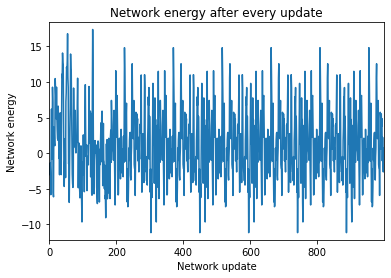

In [51]:
x = np.random.random((1,28)) 
w = np.random.random((28,28)) - 0.5
print(x)
S = activation(max_cycles=1000)

E = [s[1] for s in S[:-1]]
P = [s[0].reshape((7, 4)) for s in S[:-1]]

N = len(S) - 1

plt.plot(E)
plt.axis([-0.5, N - 0.5, min(E) - 1, max(E) + 1])
#plt.xticks(range(N), ["%d" % (x + 1) for x in range(N)])
plt.title("Network energy after every update")
plt.xlabel("Network update")
plt.ylabel("Network energy")
plt.savefig("hopfield_energy")
plt.show()

## Learning

Learning in a Hopfield network happens in a single pass. Specifically, when the network is in a specific state that needs to be learned, its synapses are updated using the Hebbian learning rule:

\begin{equation*}
    w_{i,j} = w_{j,i} = x_i~x_j
\end{equation*}

What makes this types of networks unique is that, once a specific pattern has been memoried, the network can memorize an additional one by simply re-applying the Hebbian learning rule above. Unlike feedforward networks or recurrent networks trained with CHL, Hopfield networks can learn new things without catastrophic interference.

In [52]:
def pattern(i):
    """Loads a matrix representation of a digit and turns it into a binary map"""
    p = np.loadtxt("%d.txt" % i)
    p = (p * 2) - 1  # Makes the vector binary (+1 or -1)
    return p.reshape((n_x, 1)).T
        
    
def learn(patterns):
    """Learn a given set patterns"""
    global w
    N = n_x
    new_w = np.zeros((n_x, n_x))  # New weight matrix
    
    for num in patterns:
        p = pattern(num)
        dw = p.T.dot(p)
        new_w = new_w + (dw/N) 
        
    w = new_w
        
        
def corrupt_pattern(pattern, prob = 0.2):
    """Creates a corrupted version a given pattern (with randomly flipped bits)"""
    r = np.copy(pattern)
    for i in range(r.size):
        if np.random.random() < prob:
            r[0,i] = r[0,i] * -1
    return r


def noisy_pattern(pattern, prob = 0.4):
    """Corrupts a given pattern"""
    r = np.copy(pattern)
    for i in range(r.size):
        if np.random.random() < prob:
            r[0,i] = r[0,i] * np.random.random()
    return r

### Testing learning

With these functions written, we can now test the network by having it memorize a subset of numbers.

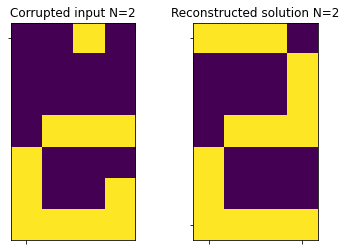

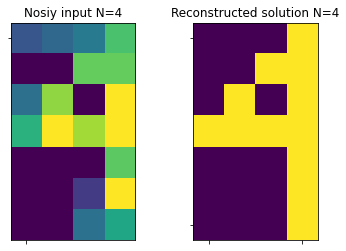

In [53]:
learn([1,2,4, 6, 7])

c_input = 2
n_input = 4

plt.subplot(1, 2, 1)
x = corrupt_pattern(pattern(c_input))
plt.title("Corrupted input N=%s" % c_input)
plt.imshow(x.reshape((7,4)), interpolation = "none")
plt.yticks([0], [""])
plt.xticks([0], [""])

activation()

plt.subplot(1, 2, 2)
plt.imshow(x.reshape((7,4)), interpolation = "none")
plt.title("Reconstructed solution N=%s" % c_input)
plt.yticks([0, 6], ["", ""])
plt.xticks([0, 3], ["", ""])
plt.savefig("figures/hopfield_noisy1.png")
plt.show()

plt.subplot(1, 2, 1)
x = noisy_pattern(pattern(4), prob=0.5)
plt.title("Nosiy input N=%s" % n_input)
plt.imshow(x.reshape((7,4)), interpolation = "none")
plt.yticks([0], [""])
plt.xticks([0], [""])

activation()

plt.subplot(1, 2, 2)
plt.imshow(x.reshape((7,4)), interpolation = "none")
plt.title("Reconstructed solution N=%s" % n_input)
plt.yticks([0, 6], ["", ""])
plt.xticks([0, 3], ["", ""])
plt.savefig("figures/hopfield_noisy2.png")
plt.show()



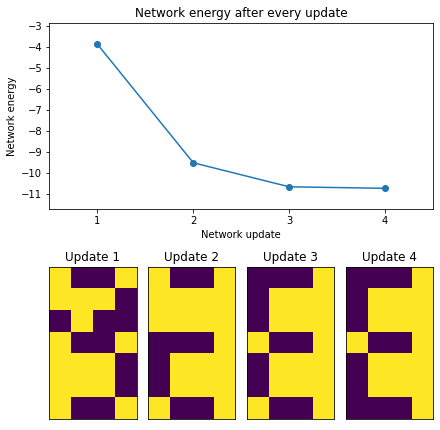

In [54]:
p = corrupt_pattern(pattern(8), prob = 0.8)
x = p
S = activation()

E = [s[1] for s in S[:-1]]
P = [s[0].reshape((7, 4)) for s in S[:-1]]

N = len(S) - 1


fig = plt.figure(figsize=(6, 6), constrained_layout=True)
gs = fig.add_gridspec(2, N)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot([x+1 for x in range(N)], E,  "o-")
ax1.axis([0.5, N + 0.5, min(E) - 1, max(E) + 1])
ax1.set_xticks([x+1 for x in range(N)])
ax1.set_title("Network energy after every update")
ax1.set_xlabel("Network update")
ax1.set_ylabel("Network energy")

for i in range(N):
    ax = fig.add_subplot(gs[1, i])
    ax.imshow(P[i], interpolation="none")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Update %s" % (i+1,))

#fig.tight_layout()
plt.savefig("figures/hopfield_updates.png")
plt.show()

[[ 1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.
   1. -1. -1. -1.  1. -1. -1. -1.  1. -1.]]


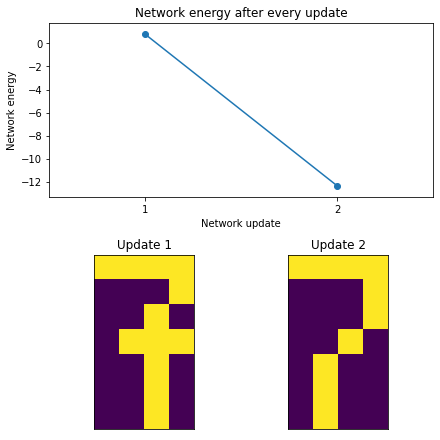

In [55]:
learn([4,6,7,8])
p = np.loadtxt("7-alternate.txt")
p = (p * 2) - 1  # Makes the vector binary (+1 or -1)
p=p.reshape((n_x, 1)).T
print(p)

x = p
S = activation()

E = [s[1] for s in S[:-1]]
P = [s[0].reshape((7, 4)) for s in S[:-1]]

N = len(S) - 1


fig = plt.figure(figsize=(6, 6), constrained_layout=True)
gs = fig.add_gridspec(2, N)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot([x+1 for x in range(N)], E,  "o-")
ax1.axis([0.5, N + 0.5, min(E) - 1, max(E) + 1])
ax1.set_xticks([x+1 for x in range(N)])
ax1.set_title("Network energy after every update")
ax1.set_xlabel("Network update")
ax1.set_ylabel("Network energy")

for i in range(N):
    ax = fig.add_subplot(gs[1, i])
    ax.imshow(P[i], interpolation="none")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Update %s" % (i+1,))

#fig.tight_layout()
plt.savefig("figures/hopfield_updates_7alternate.png")
plt.show()